## Trabajo seminario final

En este trabajo se pretende abordar la relaciones que existen entre diferentes usuarios de spotify a partir de analizar los artistas que comparten y de algún modos las similitudes en sus gustos musicales. Este estudio podría ser el puntapie de un sistema de recomendación. 

El abordaje plantea tres enfoques diferentes:

    1_ Crear una mapa de calor que muestre cuánto machean, en artistas, dos usuarios.  
    2_ Utilizar un algoritmo de clustering para visualizar grupos de usuarios con gustos similares.
    3_ Realizar un grafo del grupo de usuarios en estudio para analizar que tan interconectada es la red y cuáles son los usuario con mayor grado. Esto podría mostrar qué   usuarios interconectan más

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
pd.options.mode.chained_assignment = None  # default='warn'
import csv
from operator import itemgetter
from sqlalchemy import create_engine
import networkx as nx
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.

## conexion con bbdd postgres

armo un dataset a partir de tabla de postgres



In [2]:
# follows django database settings format, replace with your own settings
DATABASES = {
    'Musicbrainz':{
        'NAME': 'Musicbrainz',
        'USER': 'postgres',
        'PASSWORD': 'qweasd',
        'HOST': 'localhost',
        'PORT': 5432,
    },
}

#DATABASES = {
#        'SEMINARIO':{
#        'NAME': 'SEMINARIO',
#        'USER': 'airflow',
#        'PASSWORD': 'airflow',
#        'HOST': 'host.docker.internal',
#        'PORT': 5435,
#    },
#}





In [3]:
# choose the database to use
db = DATABASES['Musicbrainz']



In [4]:
# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

In [5]:
# create sqlalchemy engine
engine = create_engine(engine_string)

In [8]:
# read a table from database into pandas dataframe, replace "tablename" with your table name
df_origen = pd.read_sql_table('df_origen',engine)

In [9]:
df_origen

,user_id,artist_id
0,2,23
1,1,36
2,3,29
3,2,50
4,3,40
...,...,...
935,96,4
936,95,11
937,100,13
938,100,19


transformamos un poco el dataframe para poder alimentar un algoritmo de clusterizacion

In [11]:
intervalos=range(1,max(df_origen.artist_id)+2,1)

In [12]:
intervalos

range(1, 242)

<AxesSubplot:xlabel='artist_id', ylabel='Count'>

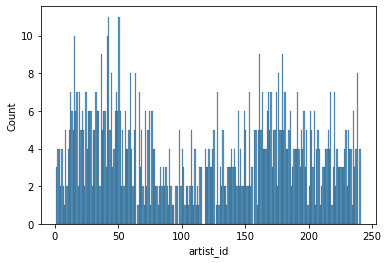

In [14]:
sns.histplot(data=df_origen, x="artist_id",bins=intervalos)

Matriz de matcheo

In [16]:
df1=df_origen
df2=df_origen
df3 = pd.merge(df1, df2, on='artist_id')


In [20]:
df3

,user_id_x,artist_id,user_id_y
0,2,23,2
1,2,23,93
2,93,23,2
3,93,23,93
4,1,36,1
...,...,...,...
4823,100,13,100
4824,94,4,94
4825,94,4,96
4826,96,4,94


In [21]:
df_std = df3.groupby(['user_id_x', 'user_id_y']).agg({'artist_id': ['count']})
df_std=df_std.reset_index()
df_std

,user_id_x,user_id_y,artist_id
,,,count
0,1,1,9
1,1,2,3
2,1,3,1
3,1,4,3
4,1,5,3
...,...,...,...
2811,100,96,2
2812,100,97,4
2813,100,98,1


In [23]:
user_1=df_std.user_id_x
user_2=df_std.user_id_y
match=df_std[('artist_id','count')]

In [24]:
df_match=pd.DataFrame()
df_match['user_1']=user_1
df_match['user_2']=user_2
df_match['match']=match

In [25]:
df_match

,user_1,user_2,match
0,1,1,9
1,1,2,3
2,1,3,1
3,1,4,3
4,1,5,3
...,...,...,...
2811,100,96,2
2812,100,97,4
2813,100,98,1
2814,100,99,2


In [26]:
m=df_match.pivot(index='user_1', columns='user_2', values='match')
m.fillna(0, inplace=True)
m

user_2,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
user_1,,,,,,,,,,,,,,,,,,,,,
1,9.0,3.0,1.0,3.0,3.0,2.0,1.0,0.0,1.0,1.0,...,4.0,5.0,2.0,2.0,3.0,1.0,2.0,1.0,2.0,3.0
2,3.0,15.0,2.0,3.0,0.0,3.0,2.0,0.0,2.0,4.0,...,1.0,3.0,3.0,1.0,3.0,3.0,1.0,2.0,0.0,1.0
3,1.0,2.0,6.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,...,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,3.0,3.0,1.0,10.0,1.0,2.0,2.0,2.0,0.0,3.0,...,1.0,2.0,3.0,1.0,3.0,1.0,3.0,2.0,0.0,3.0
5,3.0,0.0,0.0,1.0,7.0,1.0,4.0,0.0,1.0,1.0,...,2.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.0,1.0,0.0,3.0,1.0,6.0,3.0,1.0,1.0,2.0
97,2.0,1.0,1.0,3.0,0.0,2.0,1.0,3.0,0.0,0.0,...,2.0,1.0,1.0,5.0,1.0,3.0,11.0,2.0,2.0,4.0
98,1.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,2.0,1.0,1.0,2.0,6.0,0.0,1.0


In [27]:
t=np.arange(1,101,2)
t

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])

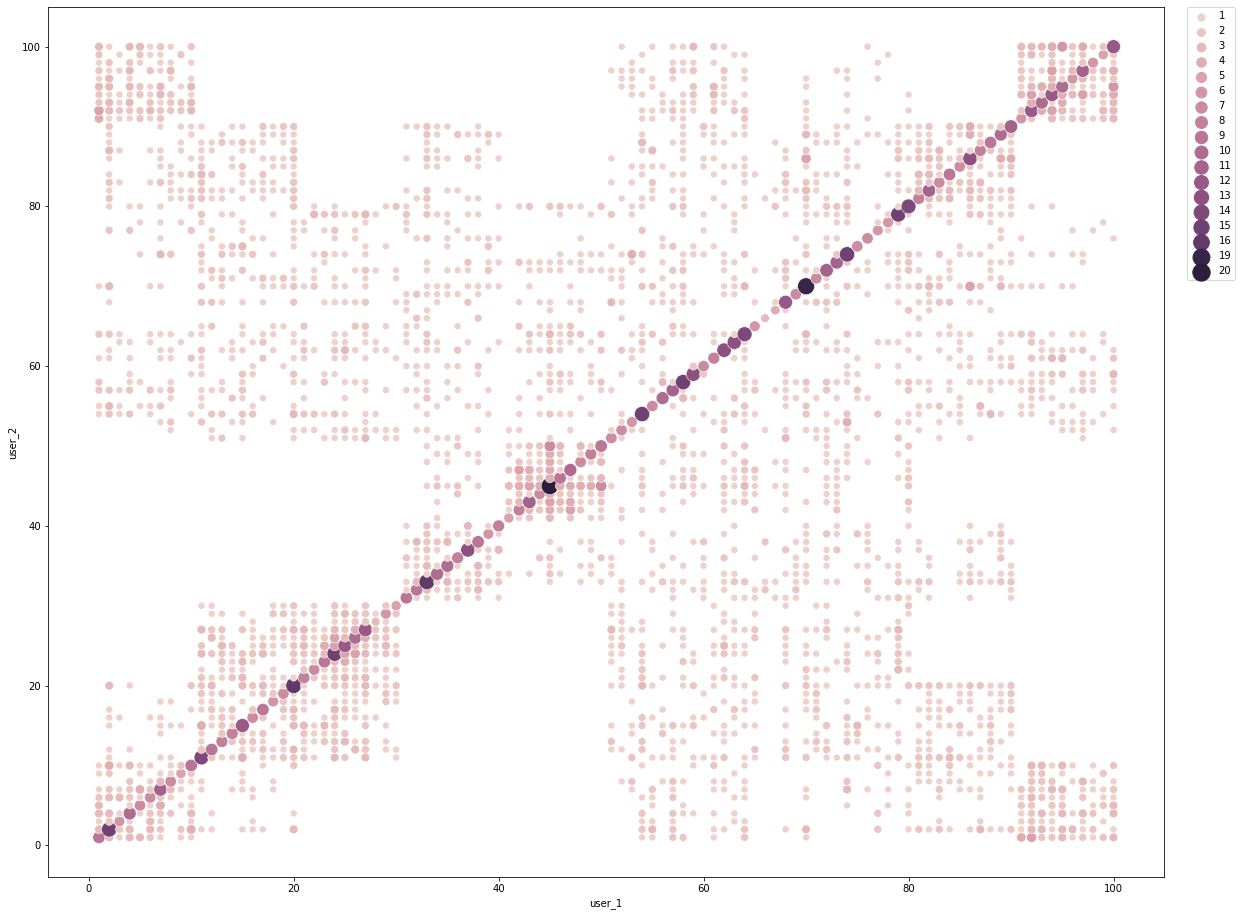

In [29]:
plt.figure(figsize=(20,16))


g=sns.scatterplot(data=df_match, x="user_1", y="user_2", hue='match', size="match",
    sizes=(50, 300),legend="full")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



## Algoritmos de clustering

### Hacemos un one hot encoder sobre la feature artista

In [30]:
data_encoded = pd.get_dummies(df_origen, columns = ['artist_id'])
data_encoded

,user_id,artist_id_1,artist_id_2,artist_id_3,artist_id_4,artist_id_5,artist_id_6,artist_id_7,artist_id_8,artist_id_9,...,artist_id_230,artist_id_231,artist_id_232,artist_id_233,artist_id_234,artist_id_235,artist_id_236,artist_id_237,artist_id_238,artist_id_240
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,96,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
936,95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
937,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
938,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df4 = data_encoded.groupby(['user_id'])[ data_encoded.columns[1:].values].sum()
df4=df4.reset_index()

In [33]:
df4

,user_id,artist_id_1,artist_id_2,artist_id_3,artist_id_4,artist_id_5,artist_id_6,artist_id_7,artist_id_8,artist_id_9,...,artist_id_230,artist_id_231,artist_id_232,artist_id_233,artist_id_234,artist_id_235,artist_id_236,artist_id_237,artist_id_238,artist_id_240
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,97,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
97,98,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
98,99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Aplicacion del modelo

In [35]:
X=df4.iloc[:,1:]
y=df4.iloc[:,0]

In [36]:
y

0       1
1       2
2       3
3       4
4       5
     ... 
95     96
96     97
97     98
98     99
99    100
Name: user_id, Length: 100, dtype: int64

k Means

In [37]:
# Importmaos la libreria
from sklearn.cluster import KMeans

# Especificamos el numero adecuado de clusters en cada caso
kmeans_1 = KMeans(n_clusters=4)


3. Entrenamos los modelos con los datos

In [38]:
kmeans_1.fit(X)


KMeans(n_clusters=4)

Luego de entrenar los modelos, podemos consultar las etiquetas que se le asignó a cada instancia y el lugar de los centroides.

In [39]:
etiquetas_1 = kmeans_1.labels_
#print(etiquetas_1.shape)
etiquetas_1

array([3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1,
       1, 1, 1, 3, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3])

In [40]:
cluster_map = pd.DataFrame()
cluster_map['user'] = y
cluster_map['cluster_KMeans'] = kmeans_1.labels_

In [41]:
cluster_map

,user,cluster_KMeans
0,1,3
1,2,3
2,3,3
3,4,3
4,5,3
...,...,...
95,96,3
96,97,3
97,98,1
98,99,3


# Grafo

In [42]:
import networkx as nx

In [43]:
df_relations=df_match[df_match['user_1']<df_match['user_2']]
df_relations.reset_index(inplace=True)

In [44]:
df_relations

,index,user_1,user_2,match
0,1,1,2,3
1,2,1,3,1
2,3,1,4,3
3,4,1,5,3
4,5,1,6,2
...,...,...,...,...
1353,2749,97,98,2
1354,2750,97,99,2
1355,2751,97,100,4
1356,2771,98,100,1


In [45]:
G = nx.from_pandas_edgelist(
    df_relations,
    source='user_1',
    target='user_2',
    #edge_labels={(source, target): match}
    #edge_key= "my_edge_key",
    #edge_attr=['match'],
    #create_using=nx.MultiGraph(),
)

In [49]:
G_weighted = nx.Graph()

In [50]:
for i in range(0, len(df_relations)):
  G_weighted.add_edge(df_relations.iloc[i,1],  df_relations.iloc[i,2],   weight=df_relations.iloc[i,3])
  

In [51]:
df_relations.iloc[:,3].describe()


count    1358.000000
mean        1.431517
std         0.759674
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: match, dtype: float64

In [52]:
elarge = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] >3 ]
emedium = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if (d['weight'] >=2 and d['weight'] <3) ]
esmall = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] <2]
plt.figure(figsize=(20,20))
pos = nx.circular_layout(G_weighted)  # positions for all nodes

<Figure size 1440x1440 with 0 Axes>

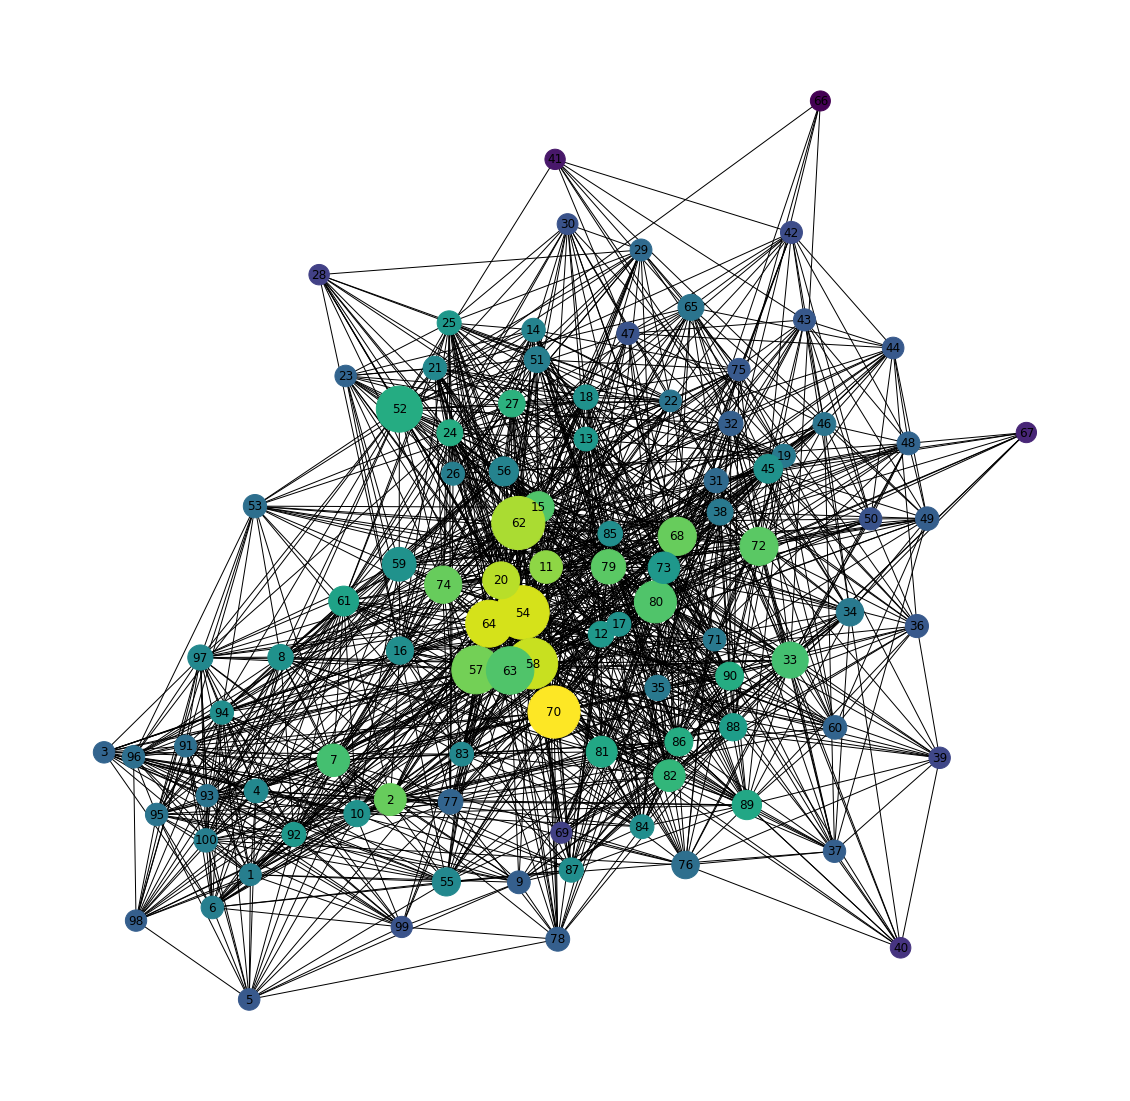

In [55]:
pos = nx.spring_layout(G_weighted,threshold=0.0001,k=0.92,dim=2,scale=.0005)
betCent = nx.betweenness_centrality(G_weighted, normalized=True, endpoints=True)
node_color = [20000.0 * G_weighted.degree(v) for v in G_weighted]
node_size =  [v*v * 1000000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_weighted, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off');

In [56]:
pos = nx.spring_layout(G_weighted.degree)
pos

{(1, 25): array([ 0.08943196, -0.96127004]),
 (2, 41): array([0.74642794, 0.57238803]),
 (3, 20): array([ 0.74250487, -0.63126309]),
 (4, 27): array([ 0.47981079, -0.64811278]),
 (5, 18): array([ 0.03143886, -0.91062574]),
 (6, 25): array([0.98495632, 0.20973491]),
 (7, 38): array([0.35383067, 0.95338626]),
 (9, 19): array([-0.4426591 , -0.85726792]),
 (10, 29): array([1.        , 0.06680168]),
 (54, 49): array([-0.60075891,  0.71453118]),
 (55, 27): array([-0.58861152, -0.76465597]),
 (57, 42): array([ 0.29224284, -0.91277542]),
 (58, 48): array([0.8873628 , 0.52484392]),
 (61, 32): array([0.02227551, 0.93855903]),
 (64, 49): array([-0.66022154, -0.64031203]),
 (70, 52): array([0.61005143, 0.82910993]),
 (91, 22): array([-0.82923414,  0.54539401]),
 (92, 30): array([-0.2053358 , -0.90301768]),
 (93, 23): array([-0.96982824,  0.04618325]),
 (94, 28): array([ 0.96256769, -0.26440263]),
 (95, 23): array([-0.84458542, -0.38843235]),
 (96, 22): array([ 0.46006782, -0.83793415]),
 (97, 27):

Algunas métricas

In [57]:
nx.clustering(G_weighted,9)

0.47368421052631576

In [58]:
nx.average_clustering(G_weighted)

0.4982721830227982

In [59]:
nx.degree_centrality(G_weighted)

{1: 0.25252525252525254,
 2: 0.4141414141414142,
 3: 0.20202020202020204,
 4: 0.27272727272727276,
 5: 0.18181818181818182,
 6: 0.25252525252525254,
 7: 0.38383838383838387,
 9: 0.19191919191919193,
 10: 0.29292929292929293,
 54: 0.494949494949495,
 55: 0.27272727272727276,
 57: 0.42424242424242425,
 58: 0.48484848484848486,
 61: 0.32323232323232326,
 64: 0.494949494949495,
 70: 0.5252525252525253,
 91: 0.22222222222222224,
 92: 0.30303030303030304,
 93: 0.23232323232323235,
 94: 0.2828282828282829,
 95: 0.23232323232323235,
 96: 0.22222222222222224,
 97: 0.27272727272727276,
 98: 0.19191919191919193,
 99: 0.17171717171717174,
 100: 0.25252525252525254,
 11: 0.4444444444444445,
 12: 0.30303030303030304,
 15: 0.393939393939394,
 16: 0.2828282828282829,
 17: 0.29292929292929293,
 20: 0.4747474747474748,
 62: 0.4646464646464647,
 68: 0.4141414141414142,
 77: 0.20202020202020204,
 80: 0.393939393939394,
 81: 0.33333333333333337,
 82: 0.36363636363636365,
 83: 0.27272727272727276,
 84: 0.28

In [60]:
nx.eigenvector_centrality(G_weighted)

{1: 0.08282728945194395,
 2: 0.1489380323274402,
 3: 0.06935035675868081,
 4: 0.08998217554688635,
 5: 0.05488310871828739,
 6: 0.08493365661257943,
 7: 0.1283633899806422,
 9: 0.06460001367282749,
 10: 0.09850469636606272,
 54: 0.16504737946189457,
 55: 0.09381512061835567,
 57: 0.13677073783976584,
 58: 0.16391433975945205,
 61: 0.1130287711322746,
 64: 0.17284074272805722,
 70: 0.18421218506802986,
 91: 0.0736844198523414,
 92: 0.10223555967056064,
 93: 0.07808500750986229,
 94: 0.09247746226981153,
 95: 0.0723424831727342,
 96: 0.074400317729978,
 97: 0.09060991841886275,
 98: 0.060041958662724486,
 99: 0.05214661239876988,
 100: 0.07833865249351751,
 11: 0.16461812619089095,
 12: 0.10984324080459583,
 15: 0.14489495880897638,
 16: 0.09818925655895984,
 17: 0.1124798754998733,
 20: 0.17063798049093054,
 62: 0.14698814688289444,
 68: 0.13976808800304888,
 77: 0.06749053528795831,
 80: 0.1321949687191171,
 81: 0.12778817184928284,
 82: 0.13035823667953353,
 83: 0.1085626998753466,
 8

In [61]:
nx.closeness_centrality(G_weighted)

{1: 0.5625,
 2: 0.6265822784810127,
 3: 0.5439560439560439,
 4: 0.5722543352601156,
 5: 0.5210526315789473,
 6: 0.5625,
 7: 0.6111111111111112,
 9: 0.532258064516129,
 10: 0.5823529411764706,
 54: 0.6644295302013423,
 55: 0.5789473684210527,
 57: 0.6346153846153846,
 58: 0.66,
 61: 0.592814371257485,
 64: 0.6644295302013423,
 70: 0.678082191780822,
 91: 0.55,
 92: 0.5823529411764706,
 93: 0.559322033898305,
 94: 0.5689655172413793,
 95: 0.5561797752808989,
 96: 0.5625,
 97: 0.5755813953488372,
 98: 0.5210526315789473,
 99: 0.5129533678756477,
 100: 0.5689655172413793,
 11: 0.6387096774193548,
 12: 0.5892857142857143,
 15: 0.6149068322981367,
 16: 0.5755813953488372,
 17: 0.5823529411764706,
 20: 0.6556291390728477,
 62: 0.6513157894736842,
 68: 0.6265822784810127,
 77: 0.55,
 80: 0.6226415094339622,
 81: 0.6,
 82: 0.6073619631901841,
 83: 0.5755813953488372,
 84: 0.5789473684210527,
 86: 0.6036585365853658,
 87: 0.5823529411764706,
 88: 0.5892857142857143,
 89: 0.6,
 90: 0.603658536585

In [62]:
nx.betweenness_centrality(G_weighted)

{1: 0.0018269563586948534,
 2: 0.012066953657247874,
 3: 0.0014544336498843661,
 4: 0.003838889671843531,
 5: 0.0015627892992071564,
 6: 0.00262031502351106,
 7: 0.01276906766049688,
 9: 0.0028570115568365218,
 10: 0.006211357335683226,
 54: 0.034201058066210745,
 55: 0.008382364932839882,
 57: 0.028588416596778094,
 58: 0.031399136113997424,
 61: 0.010074901676112765,
 64: 0.027400719013787968,
 70: 0.03279887133686523,
 91: 0.0019671406249347433,
 92: 0.003957643757148904,
 93: 0.002125699105845417,
 94: 0.0033436659069654207,
 95: 0.0024744898847978516,
 96: 0.0024502195335094415,
 97: 0.005237538428071815,
 98: 0.001339109262044358,
 99: 0.001258376410387466,
 100: 0.0034122135357313533,
 11: 0.012811749036959438,
 12: 0.005611476822337498,
 15: 0.011323217880439827,
 16: 0.007489936808183354,
 17: 0.003938928319202757,
 20: 0.017243794000756398,
 62: 0.03379528587385164,
 68: 0.018563024568095797,
 77: 0.00476327989576446,
 80: 0.02239882013153293,
 81: 0.011108061634731882,
 82: 